In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as albu

import time
import os
from tqdm.notebook import tqdm

from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [4]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [5]:
print('the number of image/label in the train: ',len(os.listdir(x_train_dir)))
print('the number of image/label in the validation: ',len(os.listdir(x_valid_dir)))
print('the number of image/label in the test: ',len(os.listdir(x_test_dir)))

the number of image/label in the train:  367
the number of image/label in the validation:  101
the number of image/label in the test:  233


In [6]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    mean=[0.144, 0.141, 0.137]
    std=[0.262, 0.261, 0.252]
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        image = t(image)
        mask = torch.from_numpy(mask).long()
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [7]:
#画像およびマスクの表示用関数

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


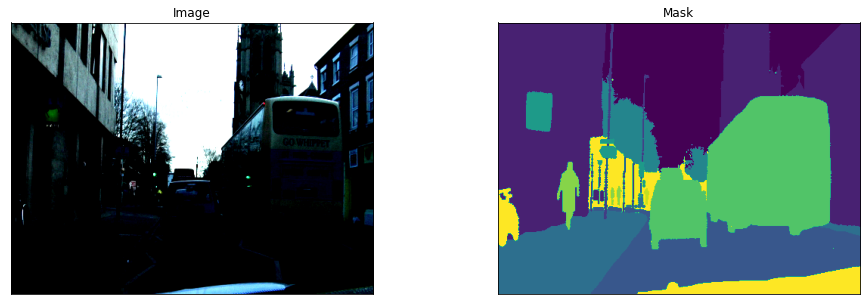

In [8]:
# Datasetの画像とマスクの確認。

dataset = Dataset(x_train_dir, y_train_dir, classes=['sky', 'building', 'pole', 'road', 'pavement', 
                                                     'tree', 'signsymbol', 'fence', 'car', 
                                                     'pedestrian', 'bicyclist', 'unlabelled'])

image, mask = dataset[5] # get some sample
visualize(
    image=image.permute(1, 2, 0), #To tensorでchannel, h, wが画像表示用と異なるため、配列変換
    mask=mask
)

In [20]:
def get_training_augmentation():
    train_transform = [


        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480),
        
    ]
    return albu.Compose(test_transform)

def test_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    #test_transform = [
    #   albu.PadIfNeeded(384, 480)
    #]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

C:\Users\Kagos\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


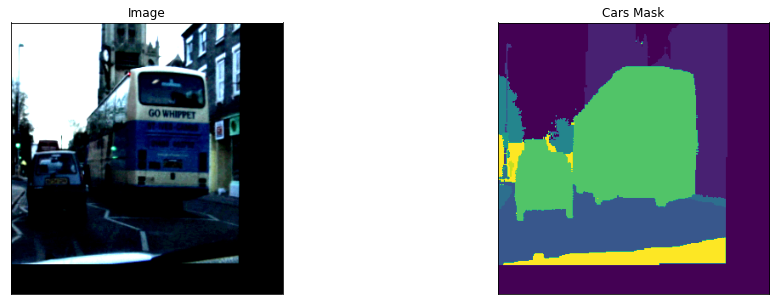

In [21]:
# Augumentation処理後の画像の確認

dataset = Dataset(x_train_dir, y_train_dir, classes=['sky', 'building', 'pole', 'road', 'pavement', 
                                                     'tree', 'signsymbol', 'fence', 'car', 
                                                     'pedestrian', 'bicyclist', 'unlabelled'], augmentation=get_training_augmentation())

image, mask = dataset[5] # get some sample
visualize(
    image=image.permute(1, 2, 0), 
    cars_mask=mask
)

In [22]:
#画像サイズの確認

image.shape

torch.Size([3, 320, 320])

In [23]:
#画像のクラスを設定

CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 'tree', 'signsymbol', 'fence', 'car', 'pedestrian', 'bicyclist', 'unlabelled']

In [24]:
#Semantic Segmentationのモデルを設定

model = smp.UnetPlusPlus('efficientnet-b4', encoder_weights='imagenet', classes=len(CLASSES), activation=None)

In [25]:
#Train, Validationのデータセットを作成

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [26]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [27]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=len(CLASSES)):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [28]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    #torch.save(model, 'Unet-_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader))) #Train途中もモデルを保存するときは実行する
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 20:
                    print('Loss not decrease for 20 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [29]:
max_lr = 1e-3
epoch = 100
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, valid_loader, criterion, optimizer, sched)

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.158 
Epoch:1/100.. Train Loss: 2.284.. Val Loss: 2.158.. Train mIoU:0.081.. Val mIoU: 0.108.. Train Acc:0.310.. Val Acc:0.378.. Time: 0.48m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 2.158 >> 1.950 
Epoch:2/100.. Train Loss: 1.958.. Val Loss: 1.950.. Train mIoU:0.121.. Val mIoU: 0.108.. Train Acc:0.492.. Val Acc:0.434.. Time: 0.41m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 1.950 >> 1.656 
Epoch:3/100.. Train Loss: 1.679.. Val Loss: 1.656.. Train mIoU:0.150.. Val mIoU: 0.152.. Train Acc:0.579.. Val Acc:0.553.. Time: 0.41m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 1.656 >> 1.408 
saving model...
Epoch:4/100.. Train Loss: 1.397.. Val Loss: 1.408.. Train mIoU:0.190.. Val mIoU: 0.205.. Train Acc:0.675.. Val Acc:0.672.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 1.408 >> 1.070 
Epoch:5/100.. Train Loss: 1.174.. Val Loss: 1.070.. Train mIoU:0.218.. Val mIoU: 0.257.. Train Acc:0.734.. Val Acc:0.773.. Time: 0.41m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 1.070 >> 0.887 
Epoch:6/100.. Train Loss: 0.974.. Val Loss: 0.887.. Train mIoU:0.241.. Val mIoU: 0.268.. Train Acc:0.775.. Val Acc:0.789.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.887 >> 0.750 
Epoch:7/100.. Train Loss: 0.819.. Val Loss: 0.750.. Train mIoU:0.266.. Val mIoU: 0.290.. Train Acc:0.797.. Val Acc:0.797.. Time: 0.41m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.750 >> 0.746 
Epoch:8/100.. Train Loss: 0.702.. Val Loss: 0.746.. Train mIoU:0.302.. Val mIoU: 0.298.. Train Acc:0.831.. Val Acc:0.796.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.746 >> 0.675 
saving model...
Epoch:9/100.. Train Loss: 0.635.. Val Loss: 0.675.. Train mIoU:0.313.. Val mIoU: 0.302.. Train Acc:0.836.. Val Acc:0.797.. Time: 0.44m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.675 >> 0.583 
Epoch:10/100.. Train Loss: 0.556.. Val Loss: 0.583.. Train mIoU:0.326.. Val mIoU: 0.318.. Train Acc:0.847.. Val Acc:0.815.. Time: 0.41m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.583 >> 0.491 
Epoch:11/100.. Train Loss: 0.529.. Val Loss: 0.491.. Train mIoU:0.361.. Val mIoU: 0.396.. Train Acc:0.857.. Val Acc:0.877.. Time: 0.41m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.491 >> 0.465 
Epoch:12/100.. Train Loss: 0.491.. Val Loss: 0.465.. Train mIoU:0.379.. Val mIoU: 0.398.. Train Acc:0.865.. Val Acc:0.871.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.465 >> 0.445 
Epoch:13/100.. Train Loss: 0.460.. Val Loss: 0.445.. Train mIoU:0.394.. Val mIoU: 0.395.. Train Acc:0.872.. Val Acc:0.877.. Time: 0.41m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:14/100.. Train Loss: 0.452.. Val Loss: 0.473.. Train mIoU:0.399.. Val mIoU: 0.402.. Train Acc:0.871.. Val Acc:0.865.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:15/100.. Train Loss: 0.433.. Val Loss: 0.510.. Train mIoU:0.412.. Val mIoU: 0.394.. Train Acc:0.875.. Val Acc:0.848.. Time: 0.43m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.510 >> 0.437 
saving model...
Epoch:16/100.. Train Loss: 0.402.. Val Loss: 0.437.. Train mIoU:0.426.. Val mIoU: 0.415.. Train Acc:0.884.. Val Acc:0.876.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.437 >> 0.405 
Epoch:17/100.. Train Loss: 0.367.. Val Loss: 0.405.. Train mIoU:0.440.. Val mIoU: 0.427.. Train Acc:0.893.. Val Acc:0.879.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:18/100.. Train Loss: 0.378.. Val Loss: 0.445.. Train mIoU:0.439.. Val mIoU: 0.409.. Train Acc:0.889.. Val Acc:0.872.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.445 >> 0.406 
Epoch:19/100.. Train Loss: 0.378.. Val Loss: 0.406.. Train mIoU:0.445.. Val mIoU: 0.423.. Train Acc:0.888.. Val Acc:0.874.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:20/100.. Train Loss: 0.376.. Val Loss: 0.434.. Train mIoU:0.442.. Val mIoU: 0.421.. Train Acc:0.887.. Val Acc:0.862.. Time: 0.43m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.434 >> 0.422 
Epoch:21/100.. Train Loss: 0.359.. Val Loss: 0.422.. Train mIoU:0.451.. Val mIoU: 0.426.. Train Acc:0.891.. Val Acc:0.876.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.422 >> 0.382 
Epoch:22/100.. Train Loss: 0.361.. Val Loss: 0.382.. Train mIoU:0.450.. Val mIoU: 0.427.. Train Acc:0.890.. Val Acc:0.880.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.382 >> 0.357 
saving model...
Epoch:23/100.. Train Loss: 0.352.. Val Loss: 0.357.. Train mIoU:0.456.. Val mIoU: 0.444.. Train Acc:0.891.. Val Acc:0.883.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:24/100.. Train Loss: 0.337.. Val Loss: 0.424.. Train mIoU:0.465.. Val mIoU: 0.429.. Train Acc:0.896.. Val Acc:0.876.. Time: 0.43m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.424 >> 0.376 
Epoch:25/100.. Train Loss: 0.345.. Val Loss: 0.376.. Train mIoU:0.458.. Val mIoU: 0.451.. Train Acc:0.892.. Val Acc:0.879.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.376 >> 0.328 
Epoch:26/100.. Train Loss: 0.322.. Val Loss: 0.328.. Train mIoU:0.473.. Val mIoU: 0.495.. Train Acc:0.899.. Val Acc:0.890.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:27/100.. Train Loss: 0.313.. Val Loss: 0.337.. Train mIoU:0.486.. Val mIoU: 0.472.. Train Acc:0.901.. Val Acc:0.878.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Epoch:28/100.. Train Loss: 0.332.. Val Loss: 0.374.. Train mIoU:0.486.. Val mIoU: 0.473.. Train Acc:0.897.. Val Acc:0.872.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 8 time
Epoch:29/100.. Train Loss: 0.314.. Val Loss: 0.395.. Train mIoU:0.499.. Val mIoU: 0.437.. Train Acc:0.899.. Val Acc:0.880.. Time: 0.43m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.395 >> 0.339 
Epoch:30/100.. Train Loss: 0.294.. Val Loss: 0.339.. Train mIoU:0.519.. Val mIoU: 0.501.. Train Acc:0.906.. Val Acc:0.892.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.339 >> 0.311 
Epoch:31/100.. Train Loss: 0.329.. Val Loss: 0.311.. Train mIoU:0.511.. Val mIoU: 0.507.. Train Acc:0.895.. Val Acc:0.898.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 9 time
Epoch:32/100.. Train Loss: 0.306.. Val Loss: 0.393.. Train mIoU:0.528.. Val mIoU: 0.508.. Train Acc:0.904.. Val Acc:0.871.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.393 >> 0.311 
saving model...
Epoch:33/100.. Train Loss: 0.307.. Val Loss: 0.311.. Train mIoU:0.525.. Val mIoU: 0.509.. Train Acc:0.903.. Val Acc:0.890.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 10 time
Epoch:34/100.. Train Loss: 0.277.. Val Loss: 0.317.. Train mIoU:0.543.. Val mIoU: 0.512.. Train Acc:0.913.. Val Acc:0.893.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.317 >> 0.284 
Epoch:35/100.. Train Loss: 0.269.. Val Loss: 0.284.. Train mIoU:0.556.. Val mIoU: 0.548.. Train Acc:0.913.. Val Acc:0.906.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 11 time
Epoch:36/100.. Train Loss: 0.256.. Val Loss: 0.299.. Train mIoU:0.579.. Val mIoU: 0.556.. Train Acc:0.917.. Val Acc:0.903.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.299 >> 0.277 
Epoch:37/100.. Train Loss: 0.244.. Val Loss: 0.277.. Train mIoU:0.581.. Val mIoU: 0.588.. Train Acc:0.921.. Val Acc:0.915.. Time: 0.41m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.277 >> 0.276 
Epoch:38/100.. Train Loss: 0.240.. Val Loss: 0.276.. Train mIoU:0.589.. Val mIoU: 0.597.. Train Acc:0.922.. Val Acc:0.917.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.276 >> 0.254 
Epoch:39/100.. Train Loss: 0.237.. Val Loss: 0.254.. Train mIoU:0.598.. Val mIoU: 0.598.. Train Acc:0.922.. Val Acc:0.916.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 12 time
Epoch:40/100.. Train Loss: 0.237.. Val Loss: 0.267.. Train mIoU:0.606.. Val mIoU: 0.636.. Train Acc:0.922.. Val Acc:0.921.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.267 >> 0.243 
saving model...
Epoch:41/100.. Train Loss: 0.234.. Val Loss: 0.243.. Train mIoU:0.613.. Val mIoU: 0.642.. Train Acc:0.923.. Val Acc:0.929.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 13 time
Epoch:42/100.. Train Loss: 0.229.. Val Loss: 0.269.. Train mIoU:0.620.. Val mIoU: 0.604.. Train Acc:0.925.. Val Acc:0.917.. Time: 0.43m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.269 >> 0.255 
Epoch:43/100.. Train Loss: 0.234.. Val Loss: 0.255.. Train mIoU:0.610.. Val mIoU: 0.609.. Train Acc:0.923.. Val Acc:0.924.. Time: 0.43m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 14 time
Epoch:44/100.. Train Loss: 0.222.. Val Loss: 0.259.. Train mIoU:0.628.. Val mIoU: 0.637.. Train Acc:0.927.. Val Acc:0.925.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.259 >> 0.249 
Epoch:45/100.. Train Loss: 0.215.. Val Loss: 0.249.. Train mIoU:0.629.. Val mIoU: 0.632.. Train Acc:0.929.. Val Acc:0.928.. Time: 0.44m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 15 time
Epoch:46/100.. Train Loss: 0.222.. Val Loss: 0.251.. Train mIoU:0.624.. Val mIoU: 0.653.. Train Acc:0.927.. Val Acc:0.928.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 16 time
Epoch:47/100.. Train Loss: 0.222.. Val Loss: 0.253.. Train mIoU:0.622.. Val mIoU: 0.637.. Train Acc:0.926.. Val Acc:0.928.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.253 >> 0.244 
Epoch:48/100.. Train Loss: 0.211.. Val Loss: 0.244.. Train mIoU:0.642.. Val mIoU: 0.652.. Train Acc:0.929.. Val Acc:0.929.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 17 time
Epoch:49/100.. Train Loss: 0.215.. Val Loss: 0.282.. Train mIoU:0.635.. Val mIoU: 0.644.. Train Acc:0.928.. Val Acc:0.919.. Time: 0.43m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.282 >> 0.247 
Epoch:50/100.. Train Loss: 0.208.. Val Loss: 0.247.. Train mIoU:0.641.. Val mIoU: 0.656.. Train Acc:0.929.. Val Acc:0.930.. Time: 0.43m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 18 time
Epoch:51/100.. Train Loss: 0.210.. Val Loss: 0.248.. Train mIoU:0.641.. Val mIoU: 0.640.. Train Acc:0.929.. Val Acc:0.929.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 19 time
Epoch:52/100.. Train Loss: 0.202.. Val Loss: 0.263.. Train mIoU:0.649.. Val mIoU: 0.643.. Train Acc:0.933.. Val Acc:0.925.. Time: 0.43m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.263 >> 0.249 
saving model...
Epoch:53/100.. Train Loss: 0.201.. Val Loss: 0.249.. Train mIoU:0.652.. Val mIoU: 0.649.. Train Acc:0.932.. Val Acc:0.927.. Time: 0.43m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.249 >> 0.242 
Epoch:54/100.. Train Loss: 0.194.. Val Loss: 0.242.. Train mIoU:0.652.. Val mIoU: 0.650.. Train Acc:0.934.. Val Acc:0.933.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Decreasing.. 0.242 >> 0.239 
Epoch:55/100.. Train Loss: 0.193.. Val Loss: 0.239.. Train mIoU:0.663.. Val mIoU: 0.652.. Train Acc:0.934.. Val Acc:0.932.. Time: 0.42m


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

Loss Not Decrease for 20 time
Loss not decrease for 20 times, Stop Training
Total time: 23.65 m


In [30]:
torch.save(model, 'UnetPlusPlus-efficientb4.pt')

In [31]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

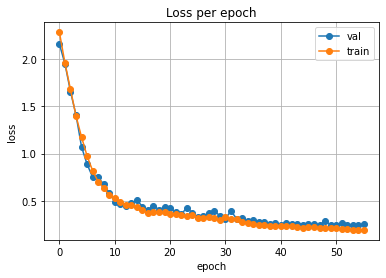

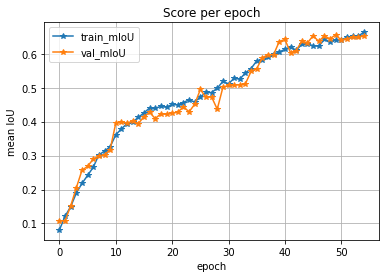

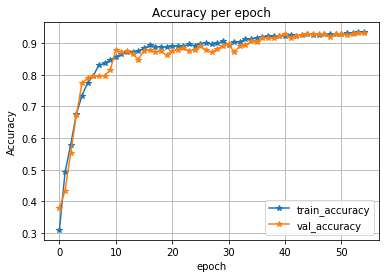

In [32]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [33]:
# load best saved checkpoint
model = torch.load('UnetPlusPlus-efficientb4.pt')

In [34]:
class testDataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        #t = T.Compose([T.ToTensor()])
        #image = t(image)
        mask = torch.from_numpy(mask).long()
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [35]:
# create test dataset
test_dataset = testDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    #preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [36]:
def predict_image_mask_miou(model, image, mask, mean=[0.144, 0.141, 0.137], std=[0.262, 0.261, 0.252]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [37]:
def predict_image_mask_pixel(model, image, mask, mean=[0.144, 0.141, 0.137], std=[0.262, 0.261, 0.252]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [38]:
image, mask = test_dataset[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [39]:
image, mask = test_dataset[3]
image.shape

(384, 480, 3)

In [40]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [41]:
mob_miou = miou_score(model, test_dataset)
print('Test Set mIoU', np.mean(mob_miou))

  0%|          | 0/233 [00:00<?, ?it/s]

Test Set mIoU 0.566334808982544


In [42]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [43]:
mob_acc = pixel_acc(model, test_dataset)
print('Test Set Pixel Accuracy', np.mean(mob_acc))

  0%|          | 0/233 [00:00<?, ?it/s]

Test Set Pixel Accuracy 0.8741606079741893


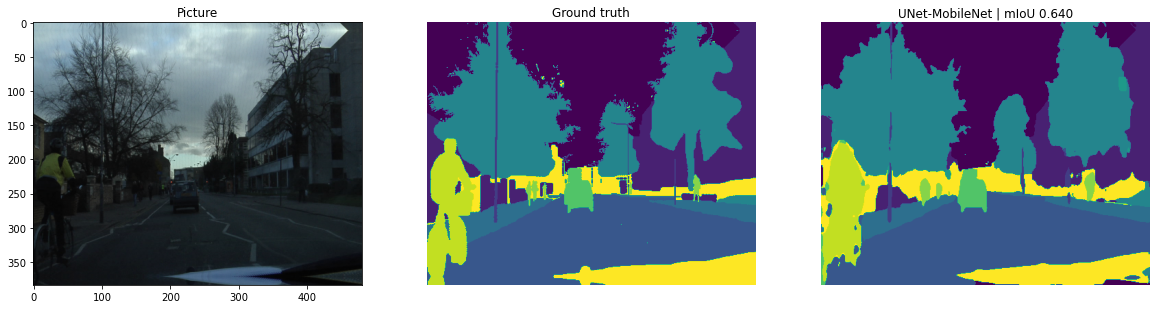

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

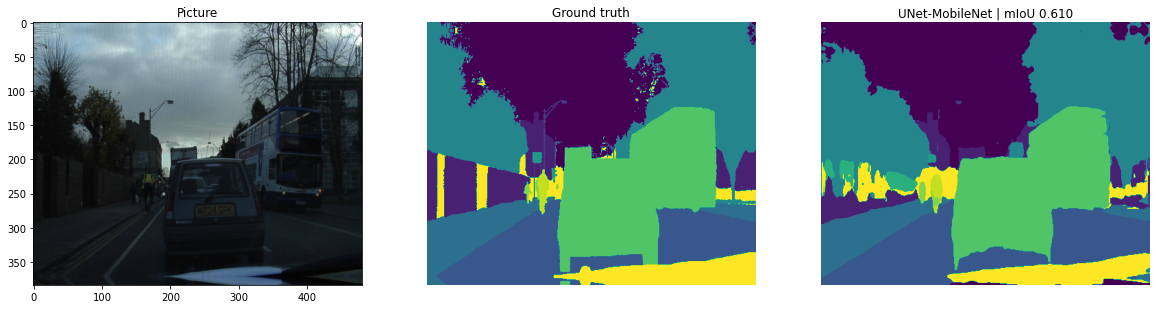

In [45]:
image2, mask2 = test_dataset[15]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

In [46]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

UNet-EfficientNet-B4 | mIoU 0.457


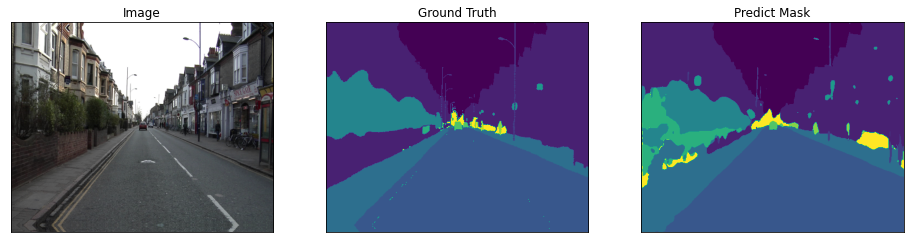

UNet-EfficientNet-B4 | mIoU 0.654


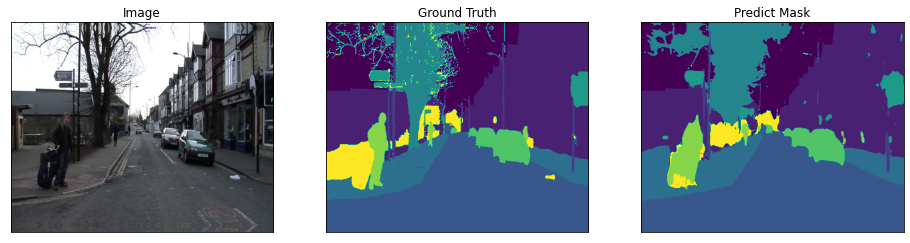

UNet-EfficientNet-B4 | mIoU 0.527


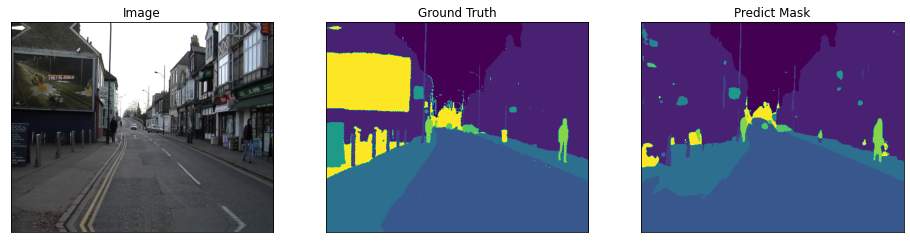

UNet-EfficientNet-B4 | mIoU 0.527


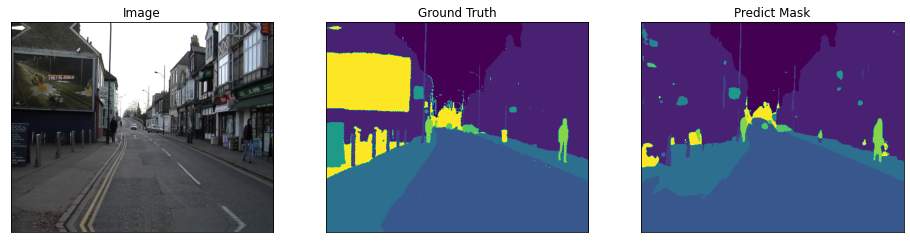

In [47]:
for i in range(4):
    n = np.random.choice(len(test_dataset))
    
    image2, mask2 = test_dataset[n]
    
    pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)
    
    print('UNet-EfficientNet-B4 | mIoU {:.3f}'.format(score2))
    
    visualize(
        image=image2, 
        ground_truth=mask2,
        predict_mask = pred_mask2,
    )